# **Классификация с помощью логистической регрессии**

**Выполнил студент ФИО**

# 1.Выберете набор данных для Классификации

Выполните импорт данных. Оцените типы имеющихся данных, проверьте наличие дубликатов и/или пропущенных значений.

* Import библиотек

In [187]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека MatPlotLib для визуализации
import seaborn as sns; sns.set() # библиотека Seaborn для визуализации данных из Pandas

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn
from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scikit-learn
from sklearn import preprocessing as prep  # общий модуль предварительной обработки scikit-learn
from sklearn import set_config # для доп настроек

from sklearn.pipeline import Pipeline # Pipeline - суперпомощник автоматизации обработки данных
from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn


from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression # Логистичекая регрессия от scikit-learn
from sklearn.preprocessing import PolynomialFeatures # Объект для генерации полиномиальных признаков от scikit-learn

RANDOM_STATE = 42
import warnings
warnings.filterwarnings('ignore')

* Загрузка и считывание датасета

Ссылка на датасет - https://www.kaggle.com/datasets/alexandrududa/cars-moldova

In [153]:
df = pd.read_csv("euro2024_players.csv", delimiter = ',')
df

,Name,Position,Age,Club,Height,Foot,Caps,Goals,MarketValue,Country
0,Marc-André ter Stegen,Goalkeeper,32,FC Barcelona,187,right,40,0,28000000,Germany
1,Manuel Neuer,Goalkeeper,38,Bayern Munich,193,right,119,0,4000000,Germany
2,Oliver Baumann,Goalkeeper,34,TSG 1899 Hoffenheim,187,right,0,0,3000000,Germany
3,Nico Schlotterbeck,Centre-Back,24,Borussia Dortmund,191,left,12,0,40000000,Germany
4,Jonathan Tah,Centre-Back,28,Bayer 04 Leverkusen,195,right,25,0,30000000,Germany
...,...,...,...,...,...,...,...,...,...,...
618,Adam Hlozek,Second Striker,21,Bayer 04 Leverkusen,188,right,31,2,12000000,Czech Republic
619,Patrik Schick,Centre-Forward,28,Bayer 04 Leverkusen,191,left,37,18,22000000,Czech Republic
620,Mojmír Chytil,Centre-Forward,25,SK Slavia Prague,187,-,12,4,6500000,Czech Republic
621,Jan Kuchta,Centre-Forward,27,AC Sparta Prague,185,right,20,3,5000000,Czech Republic


In [154]:
df.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         623 non-null    object
 1   Position     623 non-null    object
 2   Age          623 non-null    int64 
 3   Club         623 non-null    object
 4   Height       623 non-null    int64 
 5   Foot         620 non-null    object
 6   Caps         623 non-null    int64 
 7   Goals        623 non-null    int64 
 8   MarketValue  623 non-null    int64 
 9   Country      623 non-null    object
dtypes: int64(5), object(5)
memory usage: 48.8+ KB


In [155]:
df = df.dropna(subset='Foot')
df = df.drop_duplicates() # удаляем дубликаты
df = df.reset_index(drop=True) # обновим индексы
df.duplicated().sum()

0

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         620 non-null    object
 1   Position     620 non-null    object
 2   Age          620 non-null    int64 
 3   Club         620 non-null    object
 4   Height       620 non-null    int64 
 5   Foot         620 non-null    object
 6   Caps         620 non-null    int64 
 7   Goals        620 non-null    int64 
 8   MarketValue  620 non-null    int64 
 9   Country      620 non-null    object
dtypes: int64(5), object(5)
memory usage: 48.6+ KB


## 2. Выполните исследовательский анализ данных.

Оцените связь Признаков с целевой переменной (агрегация с помощью метода groupby библиотеки Pandas).

In [157]:
# делим признаки на котегориальные и числовые

cat_columns = [] # создаем пустой список для имен колонок категориальных данных
num_columns = [] # создаем пустой список для имен колонок числовых данных

for column_name in df.columns: # смотрим на все колонки в датафрейме
    if (df[column_name].dtypes == object): # проверяем тип данных для каждой колонки
        cat_columns +=[column_name] # если тип объект - то складываем в категориальные данные
    else:
        num_columns +=[column_name] # иначе - числовые

# важно: если признак категориальный, но хранится в формате числовых данных, тогда код не сработает корректно


# выводим результат
print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))


Категориальные данные:	  ['Name', 'Position', 'Club', 'Foot', 'Country'] 
 Число столблцов =  5
Числовые данные:	  ['Age', 'Height', 'Caps', 'Goals', 'MarketValue'] 
 Число столблцов =  5


Удалим зависимые параметры, Age более информативный, поэтому его сгенерируем, а Year удалим.

Сразу изменим список числовых признаков.

In [158]:
df[cat_columns].nunique()

Name        620
Position     13
Club        216
Foot          4
Country      24
dtype: int64

In [159]:
# Признак Author также имеет много значений, посмотрим количество уникальных
counts = df.Foot.value_counts()
counts

Foot
right    436
left     150
both      31
-          3
Name: count, dtype: int64

In [160]:
df = df.drop(df[df.Foot == '-'].index) #Удалим строки где нет ноги
#df = df.loc[df.Foot == 'both', 'Foot'] = 'right'
df = df.drop(df[df.Foot == 'both'].index) #Удалим строки где нет ноги
#df['Foot'] = np.where(df.Foot == 'both', 'right', df.Foot) #Сделаем бинарным

In [161]:
counts = df.Foot.value_counts()
counts

Foot
right    436
left     150
Name: count, dtype: int64

Выбираем переменную Transmission как целевую.

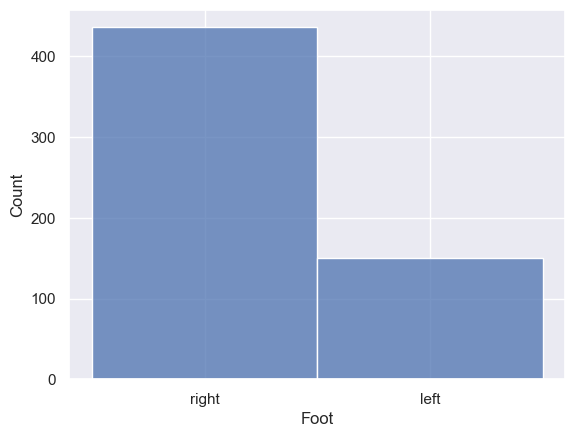

In [162]:
# Посмотрим как выглядит распределение целевой переменной.
target = "Foot"
sns.histplot(
    df,
    x=target
)

classification_df=df.copy()

In [163]:
# Группировка по признакам и расчет количества значений целевой переменной
classification_df.groupby('Foot').count()

,Name,Position,Age,Club,Height,Caps,Goals,MarketValue,Country
Foot,,,,,,,,,
left,150,150,150,150,150,150,150,150,150
right,436,436,436,436,436,436,436,436,436


<Figure size 1000x1000 with 0 Axes>

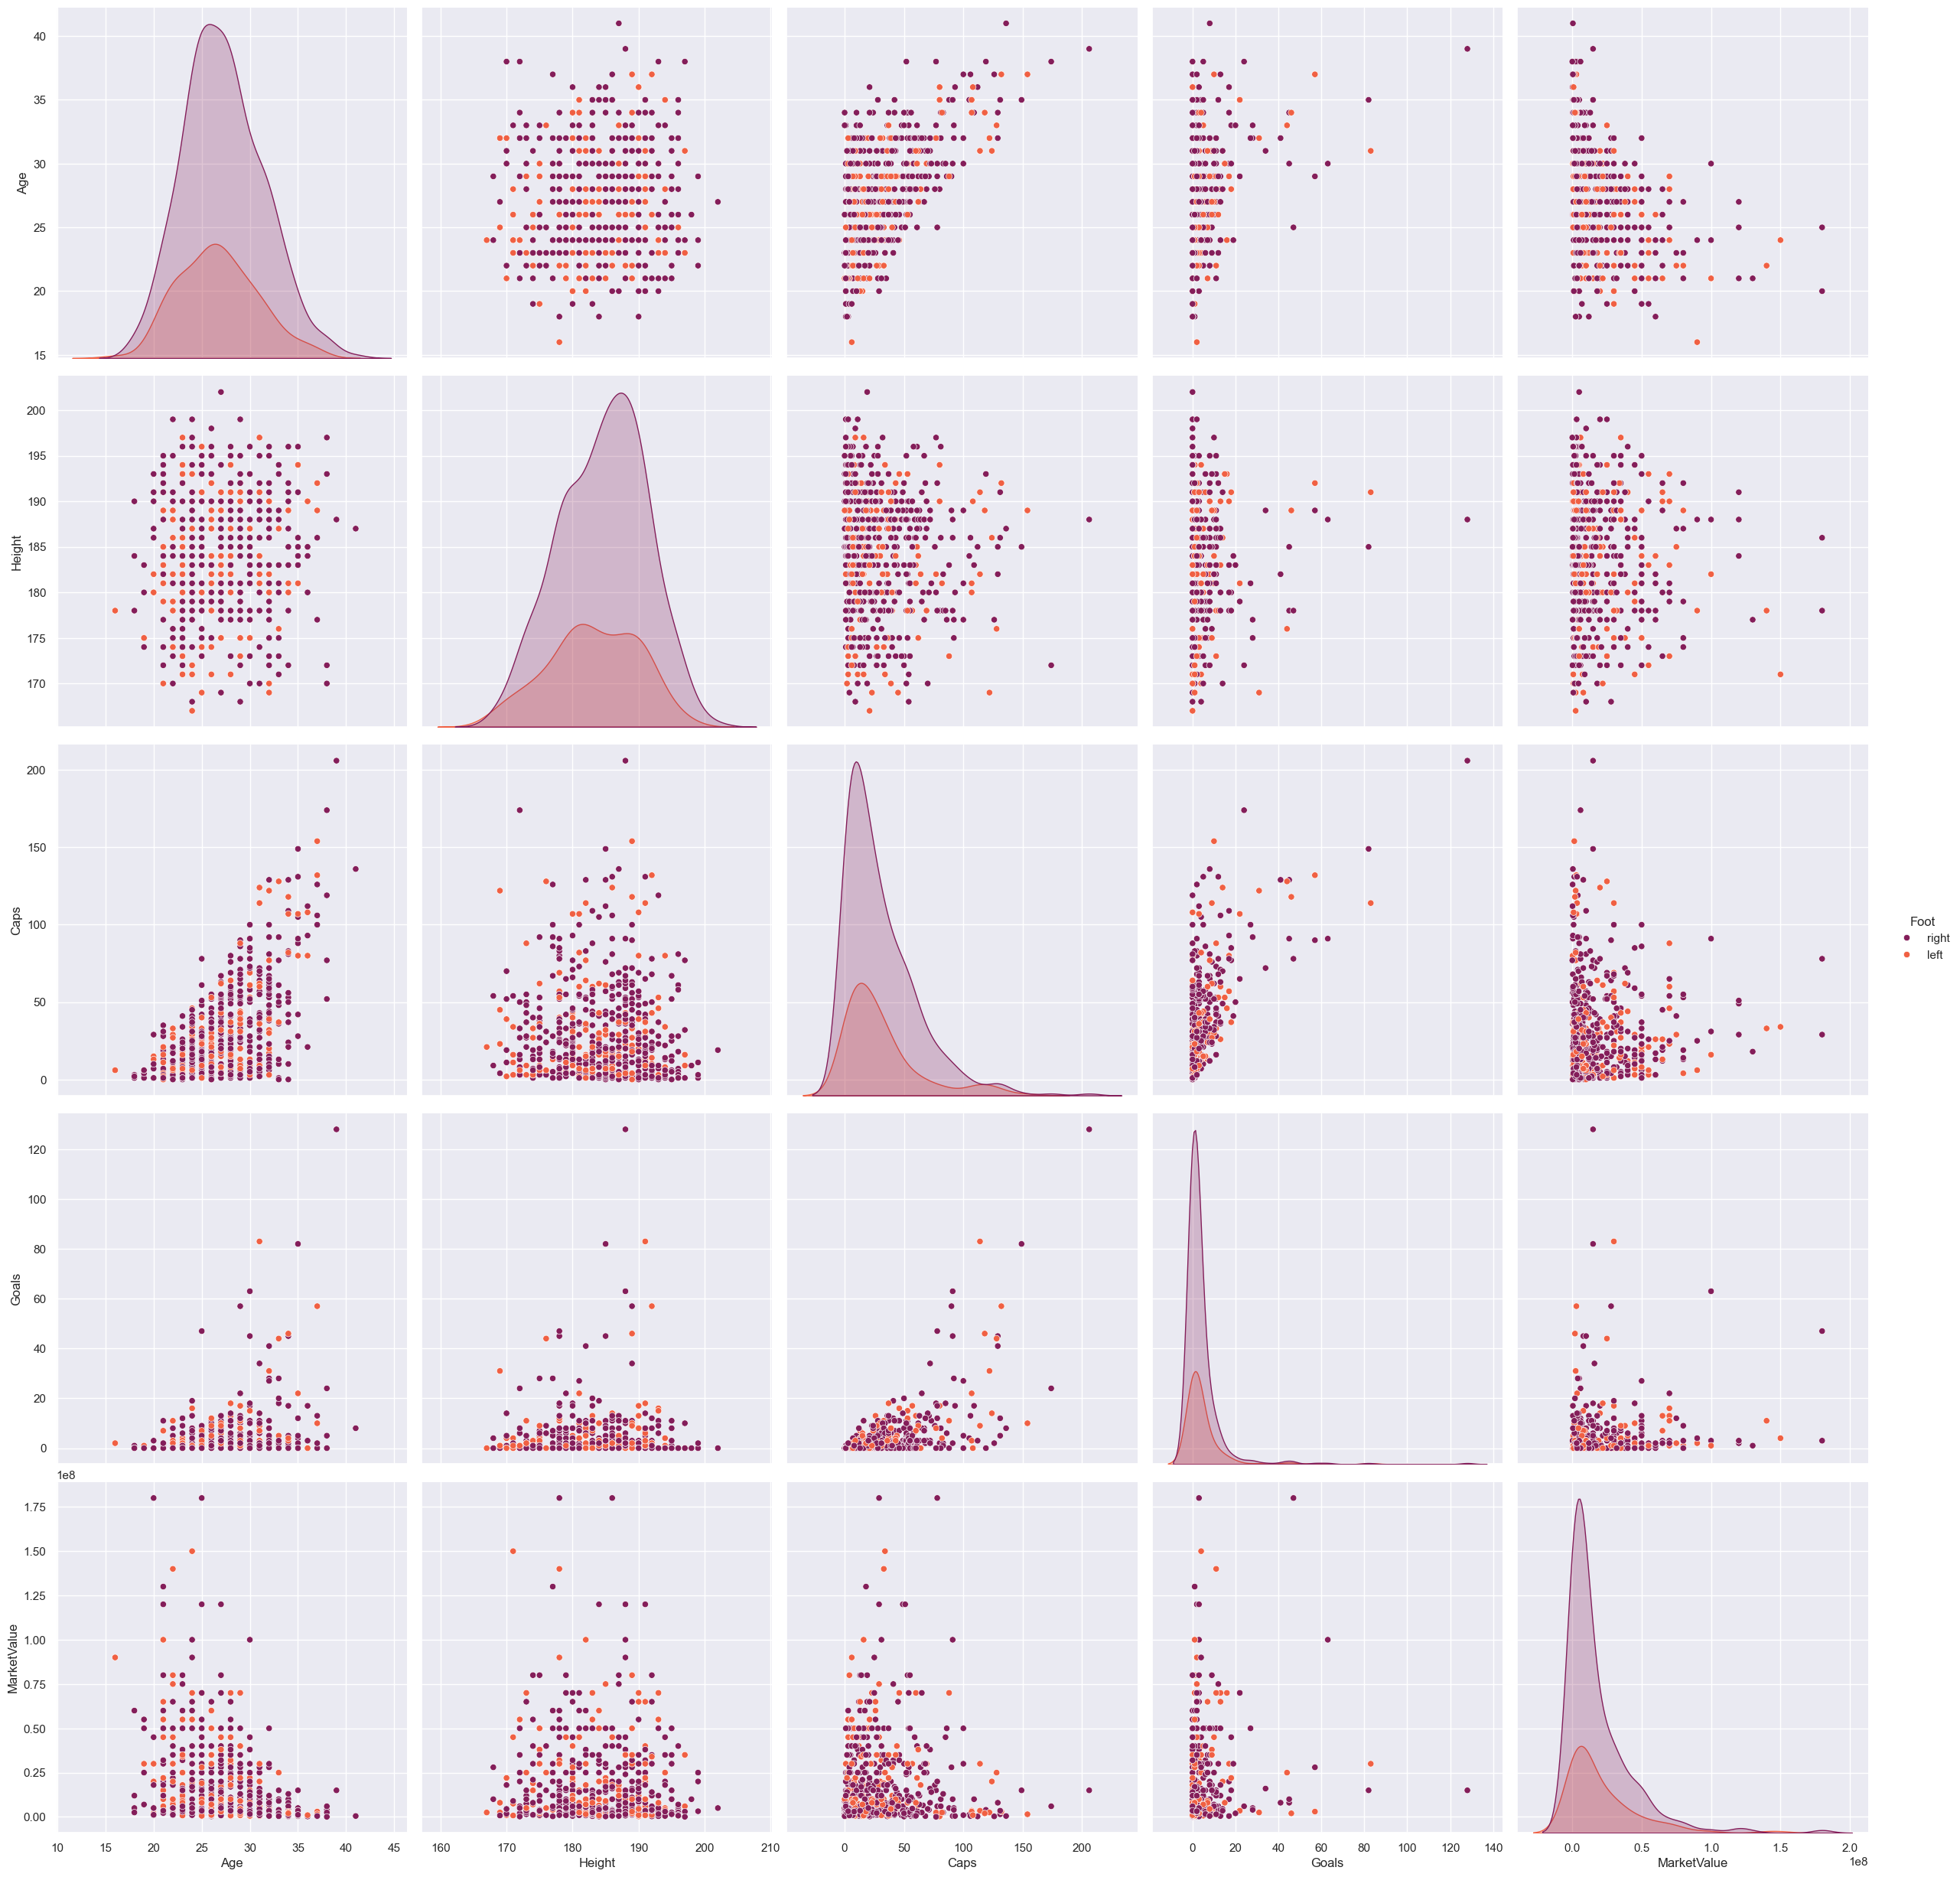

In [164]:
# визуализируем распределение целевой переменной по отношению к числовым признакам
fig = plt.figure(figsize=(10, 10))
sns.pairplot(data = classification_df[['Age', 'Height', 'Caps', 'Goals', 'MarketValue','Foot']],
              hue ='Foot',
              palette = 'rocket',
              height=5);

Целевая переменная "Manual" преобладает в признаках. Исключение "Price(Euro) - тут преобладает "Automatic".

# 3.Выполните адекватную предварительную обработку данных

Выполните адекватную предварительную обработку данных разными методами. Разные методы означают стандартизацию, нормализацию и степенное преобразование для числовых признаков и порядковое/one-hot кодирование для категориальных.



* Разделим датасет на признаки и целевые метки

Для задачи классификации выделим признак 'Transmission' в отдельный целевой датасет. Остальные признаки будут данными для тренировки модели.

In [165]:
data = df.drop(columns = ['Foot']) # признаках не нужен 'Transmission' - удаляем
target = df['Foot'] # поскольку это целевая метка

Сразу скорректируем список категориальных признаков

In [166]:
cat_columns.remove('Foot') # уберем Целевую метку из списка категориальных данных


In [167]:
cat_columns

['Name', 'Position', 'Club', 'Country']

Приводим целевые метки к 0 и 1 (0 это 'Automatic', а 1 это 'Manual')



In [168]:
Label = prep.LabelEncoder()
Label.fit(target) # задаем столбец, который хотим преобразовать
Label.classes_ # в аттрибуте .classes_ хранится информация "какой класс как шифруется"
Label_encoded = Label.transform(target) # преобразуем и сохраняем в новую переменную
Label_encoded

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,

Разбиваем на тестовую и тренировочную выборку.

In [169]:
X_train, X_val, y_train, y_val = train_test_split(data,Label_encoded,
                                                  test_size = 0.2,
                                                  random_state = RANDOM_STATE)

* Выполним нормализацию и порядковое/one-hot кодирование.

* Создаем объект `Pipeline`

На вход ему подаем список из того, что мы хотим объединить в формате:
строка- название (даем имя Объекту)
сам объект (с заданными аргументами, если необходимо)

Сначала создадим отдельно Pipeline для числовых данных

In [170]:
# Pipeline предобработки числовых данных - нормализация
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),

    ('scaler', MinMaxScaler())

])

In [171]:
numerical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())])

Теперь для категориальных

In [172]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [173]:
categorical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

* Объединяем в единый Трансформер Колонок Данных

Объект `ColumnTransformer` имеет в целом схожий синтаксис с `Pipeline`

т.е. на вход ему также подаем список из того, что мы хотим объединить в формате:

* строка - название (даем имя Объекту)
* сам объект (в этом случае подаем объекты Pipeline)
* добавляется еще список названий столбцов, к которым мы применяем эти преобразования


In [174]:
preprocessors = ColumnTransformer(transformers=[ # передадим пайплайны для объединения в один процесс
    ('num', numerical_pipe, num_columns),
    ('cat', categorical_pipe, cat_columns)
])

In [175]:
preprocessors

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'Height', 'Caps', 'Goals',
                                  'MarketValue']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Name', 'Position', 'Club', 'Country'])])

# 4.Разделите данные на тренировочную и валидационную выборку.

Разделите данные на тренировочную и валидационную выборку. Определитесь с метриками, по которым вы будете оценивать модель. Учитывайте дисперсию целевой переменной.

Данные на тренировочные и валидационные мы уже разбили. Определимся с метриками.

Создаем функции метрик для оценки модели.

In [176]:
def accuracy(model_pipe, X, y):
  y_model = model_pipe.predict(X)
  return accuracy_score(y, y_model)

def recall(model_pipe, X, y):
  y_model = model_pipe.predict(X)
  return recall_score(y, y_model)

def precision(model_pipe, X, y):
  y_model = model_pipe.predict(X)
  return precision_score(y, y_model)

Обучаем стандартно через `.fit()`

Тут важно, что на вход мы подаем датафреймы, т.к. в них есть колонки к которым мы обращаемся по именам. Внимательно следите за названиями колонок, он проверяет всё добуквенно

In [177]:
preprocessors.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'Height', 'Caps', 'Goals',
                                  'MarketValue']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Name', 'Position', 'Club', 'Country'])])

* Проверим, что трансформер колонок работает.

Чисто в тестовых и ознакомительных целях посмотрим на датасет после преобразования.

In [178]:
cat_ohe_names = preprocessors.transformers_[1][1]['encoder'].get_feature_names_out(cat_columns)
cat_ohe_names

array(['Name_Aaron Ramsdale', 'Name_Abdülkerim Bardakcı',
       'Name_Adam Buksa', 'Name_Adam Wharton', 'Name_Adrian Rus',
       'Name_Adrian Șut', 'Name_Adrien Rabiot', 'Name_Ahmetcan Kaplan',
       'Name_Alejandro Grimaldo', 'Name_Aleksandar Mitrovic',
       'Name_Alessandro Bastoni', 'Name_Alex Meret', 'Name_Alexander Bah',
       'Name_Alexander Prass', 'Name_Alexandru Cicâldău',
       'Name_Alphonse Areola', 'Name_Altay Bayındır', 'Name_Amadou Onana',
       'Name_Amir Abrashi', 'Name_Anatoliy Trubin', 'Name_Anders Dreyer',
       'Name_Andraz Sporar', 'Name_Andreas Christensen',
       'Name_Andreas Skov Olsen', 'Name_Andreas Weimann',
       'Name_Andrei Burcă', 'Name_Andrei Rațiu', 'Name_Andrew Robertson',
       'Name_Andrija Zivkovic', 'Name_Andriy Lunin',
       'Name_Andriy Yarmolenko', 'Name_András Schäfer', 'Name_Angus Gunn',
       'Name_Ante Budimir', 'Name_Anthony Gordon', 'Name_Anthony Ralston',
       'Name_Antoine Griezmann', 'Name_Antonio Rüdiger',
       'Nam

Выполняем преобразование тренировочных данных.


In [179]:
train_data = preprocessors.transform(X_train) # преобразуем данные
columns = np.append(num_columns, cat_ohe_names) # объединяем названия колонок
pd.DataFrame(train_data, columns=columns,) #смотрим на датафрейм

,Age,Height,Caps,Goals,MarketValue,Name_Aaron Ramsdale,Name_Abdülkerim Bardakcı,Name_Adam Buksa,Name_Adam Wharton,Name_Adrian Rus,...,Country_Portugal,Country_Romania,Country_Scotland,Country_Serbia,Country_Slovakia,Country_Slovenia,Country_Spain,Country_Switzerland,Country_Turkiye,Country_Ukraine
0,0.826087,0.53125,0.509709,0.031250,0.005562,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.478261,0.62500,0.184466,0.015625,0.015573,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.521739,0.65625,0.286408,0.023438,0.249166,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.608696,0.56250,0.101942,0.023438,0.010011,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.217391,0.43750,0.033981,0.000000,0.082314,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.304348,0.21875,0.033981,0.000000,0.004449,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,0.521739,0.12500,0.014563,0.000000,0.249166,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
465,0.391304,0.71875,0.131068,0.062500,0.110122,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466,0.521739,0.46875,0.169903,0.046875,0.029477,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Аналогично с валидационными.

In [180]:
val_data = preprocessors.transform(X_val)
pd.DataFrame(val_data, columns=columns,)

,Age,Height,Caps,Goals,MarketValue,Name_Aaron Ramsdale,Name_Abdülkerim Bardakcı,Name_Adam Buksa,Name_Adam Wharton,Name_Adrian Rus,...,Country_Portugal,Country_Romania,Country_Scotland,Country_Serbia,Country_Slovakia,Country_Slovenia,Country_Spain,Country_Switzerland,Country_Turkiye,Country_Ukraine
0,0.695652,0.90625,0.281553,0.000000,0.002781,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.608696,0.34375,0.033981,0.000000,0.008343,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.086957,0.34375,0.004854,0.000000,0.065628,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.478261,0.56250,0.019417,0.000000,0.154616,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.434783,0.40625,0.165049,0.031250,0.043382,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.608696,0.31250,0.135922,0.000000,0.065628,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.956522,0.09375,0.252427,0.039062,0.012792,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
115,0.608696,0.34375,0.378641,0.132812,0.110122,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0.434783,0.65625,0.179612,0.031250,0.193548,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Посмотрим размерности созданных выборок

In [181]:
# Посмотрим размерности созданных выборок
display(X_train.shape)
display(X_val.shape)
display(y_train.shape)
display(y_val.shape)

(468, 9)

(118, 9)

(468,)

(118,)

# 5.Выберите модель машинного обучения.

Выберите модель машинного обучения. Это должна быть модель логистической регрессии.

* Классификация Методом Логистической регрессии

In [182]:
pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression(C=0.001, random_state=42))
])

In [183]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Height', 'Caps',
                                                   'Goals', 'MarketValue']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Name', 'Position', 'Club',
                                                   'Country'])])),
                ('model', LogisticRegression(C=0.001, random_state=42))])

In [184]:
print(f"accuracy на тренировочной выборке: {accuracy(pipe, X_train, y_train):.4f}")
print(f"accuracy на валидационной выборке: {accuracy(pipe, X_val, y_val):.4f}")

accuracy на тренировочной выборке: 0.7329
accuracy на валидационной выборке: 0.7881


In [185]:
print(f"recall на тренировочной выборке: {recall(pipe, X_train, y_train):.4f}")
print(f"recall на валидационной выборке: {recall(pipe, X_val, y_val):.4f}")

recall на тренировочной выборке: 1.0000
recall на валидационной выборке: 1.0000


In [186]:
print(f"recall на тренировочной выборке: {precision(pipe, X_train, y_train):.4f}")
print(f"recall на валидационной выборке: {precision(pipe, X_val, y_val):.4f}")

recall на тренировочной выборке: 0.7329
recall на валидационной выборке: 0.7881


## Вывод

Исходя из этих данных, можно сделать вывод, что модель неплохо обучилась. Если добавить новые параметры, то точность на валидационной выборке будет лучше.